# PROJECT: Course Optimization for Data Science
## Optimization strategies for (Rank-)Support Vector Machines (SVM)

Some imports

In [ ]:
%matplotlib inline
import numpy as np
from scipy import linalg
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install -c conda-forge cvxopt`

(if you're using conda)

or

`pip install cvxopt`

See https://cvxopt.org/install/ for instructions.

If you **struggle too much please contact us**. Don't waste time with this!

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

*   Élément de liste
*   Élément de liste



<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

**Answer 1:**

First, a problem $(\mathcal{P}):~~\min_{x\in \mathcal{C}}f(x)$ is convex if both of $f$ and $\mathcal{C}$ are convex.

Here we have: $f: (w,b) \mapsto \frac{1}{2} w^Tw = \frac{1}{2} \|w\|^2$ is clearly a convex function.

Let's justify that the set $\mathcal{C} = \left\{(w,b)\in \mathbb{R}^d\times \mathbb{R};y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}\right\} $ is convex:

$\mathcal{C}$ is convex if and only if any convex combinations of elements in $\mathcal{C}$ are also in $\mathcal{C}$.

Let $w_j, b_j \in \mathcal{C}$ and $\lambda_j \in[0,1]$ such that $\sum_{j=1}^p \lambda_j = 1$


$\forall i \in  [\![1;n]\!]$ and $\forall j \in [\![1;p]\!]$

\begin{align}
 y_{i}(w^{\top}x_{i}+b)\geq 1 &\implies \forall i \in  [\![1;n]\!], y_i \left( ( \sum_j \lambda_j w_j^T)x_i + \sum_j \lambda_j b_j \right) \geq 1 \\
&\implies \left( \sum_j \lambda_j w_j, \sum_j b_j \right) \in \mathcal{C}
\end{align}
Hence, $\mathcal{C}$ is a convex set. Thus, the problem $(\mathcal{P})$ is convex.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:</li>
    </ul>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

Remark: We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.
</div>

**Answer 2:**

The Lagrangien of the problem $(\mathcal{P})$ is defined as 
$$ \mathcal{L}(w,b,\mu) = \frac{1}{2} \|w\|^2 + \sum_{i=1}^n \mu_i[1- y_{i}(w^{\top}x_{i}+b)]$$
such that
\begin{align}
 \mathcal{L}(w,b,\mu) =& \frac{1}{2} \|w\|^2 + \sum_{i=1}^n \mu_i -  \sum_{i=1}^n \mu_i y_{i}w^{\top}x_{i} - \sum_{i=1}^n \mu_i b  y_{i}\\
 =& \frac{1}{2} \|w\|^2 +  \sum_{i=1}^n \mu_i(1-by_i) -\sum_{i=1}^n  \mu_i y_i x_i^Tw
\end{align}
We define the primal problem as
  $$(\mathcal{P}):\inf_{w,b}\sup_{\mu\geq 0}  \mathcal{L}(w,b,\mu) $$
and the dual is defined as 
    $$(\mathcal{D}):\sup_{\mu\geq 0} ~~\underbrace{\inf_{w,b} \mathcal{L}(w,b,\mu)}_{*} $$
where $(*)$ is an unconstrained minimization problem that can be solved easily; by computing its partial derivatives and the stationnary points.    

The partial derivatives of the Lagrangian are given by 
$$
 \left\{
    \begin{array}{ll}
       \frac{\partial \mathcal{L} }{\partial w} = w - \sum_{i=1}^n \mu_i y_i x_i \\
        \frac{\partial \mathcal{L} }{\partial b} = \sum_{i=1}^n \mu_i y_i .
    \end{array}
\right.
$$
thus, 
$$
 \left\{
    \begin{array}{ll}
       \frac{\partial \mathcal{L} }{\partial w} =& 0 \iff w^* &= \sum_{i=1}^n \mu_i y_i x_i  \\
        \frac{\partial \mathcal{L} }{\partial b} =& 0 \iff \mu^{\top}y&=0
    \end{array}
\right.
$$

The Langrangian function of $w$ and $b$ is convex , thus its stationnary point is a miminizer.

We plug the solution in the Lagrangian, obtaining:
\begin{align}
\inf_{w,b} \mathcal{L}(w,b,\mu)=& \frac{1}{2} \|\sum_{i=1}^n \mu_i y_i x_i  \|^2 +  \sum_{i=1}^n \mu_i  - \sum_{i,j=1}^n \mu_i y_i x_i^{\top}\mu_jy_jx_j\\
=& -\frac{1}{2} \sum_{i,j=1}^n \mu_i \mu_j x_i^{\top}x_j y_i y_j +  \sum_{i=1}^n \mu_i \\
=& -\frac{1}{2} \sum_{i,j=1}^n \mu_i y_i x_i^{\top}x_jy_j\mu_j + \mu^{\top}u 
\end{align}

where $u = (1, \dots, 1) \in \mathbb{R}^n$.

The dual problem can now be written as
$$ (\mathcal{D}):~~~~~~~\sup_{\mu\geq 0 \\  \mu^{\top}y=0} -\frac{1}{2} \sum_{i,j=1}^n \mu_i y_i x_i^{\top}x_jy_j\mu_j + \mu^{\top}u  $$
$$ \iff  \inf_{\mu\geq 0 \\  \mu^{\top}y=0} \frac{1}{2} \sum_{i,j=1}^n \mu_i y_i x_i^{\top}x_jy_j\mu_j - \mu^{\top}u $$

Let $$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

Hence, the dual problem is given by 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \inf_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& \mu \geq  0
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:</li>
    </ul>
    $$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$
</div>

**Answer 3:**

Let $x$ be a new point.  The aim of our model is to classify the data points in function of their positions with respect to the hyperplane. We assign the class $1$  to the points for which $w^{\top}x+b \geq 0 $, else the class $-1$ is assigned.

 The prediction of $y$ is given by 
$$y = \mathrm{sign}(w^{\top}x+b) $$

Now let $w^*$ be the primal solution such that  $w^* = \sum_{i=1}^n \mu_i y_i x_i$ where $\mu$ is the dual solution. Hence
$$
y = \mathrm{sign}\left(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b\right) \enspace .
$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [ ]:
#from svm_project_utils import plot_dataset, datasets

import matplotlib.pyplot as plt
import numpy as np


def datasets(name, n_points, sigma=None):
    """Generate artificial datasets

    Parameters
    ----------
    name : str
        The name of dataset. Can be "mixture", "gaussian", "checkers" or "clowns".
    n_points : int
        The number of simulated points.
    sigma : float
        The standard deviation of the noise.

    Returns
    -------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets. 1 or -1 for each sample.


    Notes
    -----
    'mixture'  : 2 classes
    First class is a a mixture of gaussian
    which takes in sandwiches the second class

    'gaussian' : is a classical dataset with two gaussianly distributed
    classes with similar variances but different means

    'checkers': Checkers

    'clowns' : The Clowns
    """
    X = []
    y = []

    if name == 'mixture':
        if sigma is None:
            sigma = 1

        n_points = n_points // 3
        x1 = sigma * np.random.randn(n_points) + 0.3
        x2 = sigma * np.random.randn(n_points) - 0.3
        x3 = sigma * np.random.randn(n_points) - 1
        y1 = sigma * np.random.randn(n_points) + 0.5
        y2 = sigma * np.random.randn(n_points) - 0.5
        y3 = sigma * np.random.randn(n_points) - 1
        X = np.c_[np.r_[x1, x2, x3], np.r_[y1, y2, y3]]
        y = np.concatenate([np.ones(n_points), -np.ones(n_points), np.ones(n_points)])
    elif name == 'gaussian':
        n_points = n_points // 2
        if sigma is None:
            sigma = 1.5
        x1 = sigma * np.random.randn(n_points, 2) + [2, 1]
        x2 = sigma * np.random.randn(n_points, 2) + [-2, -2]
        X = np.r_[x1, x2]
        y = np.concatenate([np.ones(n_points), -np.ones(n_points)])
    elif name == 'checkers':
        nb = n_points // 16
        for i in range(-2, 2):
            for j in range(-2, 2):
                this_X = np.c_[i + np.random.rand(nb), j + np.random.rand(nb)]
                if len(X) == 0:
                    X = this_X
                else:
                    X = np.r_[X, this_X]
                y = np.r_[y, (2 * ((i + j + 4) % 2) - 1) * np.ones(nb)]
    elif name == 'clowns':
        if sigma is None:
            sigma = 0.1

        n_points = n_points // 2
        x1 = 6 * np.random.rand(n_points, 1) - 3
        x2 = x1 ** 2 + np.random.randn(n_points, 1)
        x0 = sigma * np.random.randn(n_points, 2)
        x0 += np.ones((n_points, 1)).dot([[0, 6]])
        X = np.r_[x0, np.c_[x1, x2]]
        X -= np.mean(X, axis=0)[np.newaxis, :]
        X /= np.std(X, axis=0)[np.newaxis, :]
        y = np.r_[np.ones(n_points), -np.ones(n_points)]
    return X, y


def plot_dataset(X, y):
    plt.plot(X[y > 0, 0], X[y > 0, 1], 'rx')
    plt.plot(X[y < 0, 0], X[y < 0, 1], 'bx')

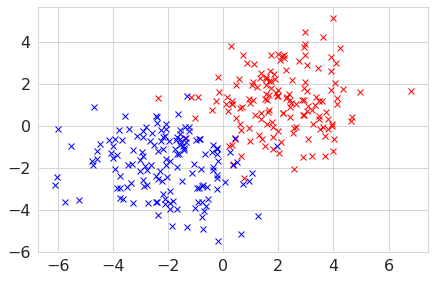

In [ ]:
X, y = datasets(name='gaussian', n_points=300)

sns.set_style("whitegrid")
#sns.set_style("ticks")
plt.figure(figsize=(7,4.5))
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [ ]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(A, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(b)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [ ]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>Modify the following cell to solve the SVM dual problem:</li>
    </ul>
</div>

Number of support vectors: 3


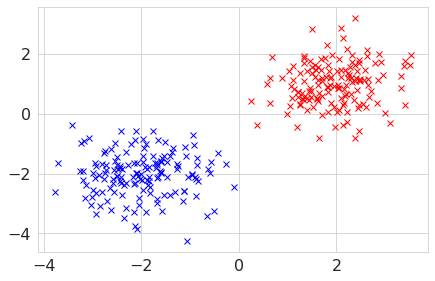

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
n, d = X.shape

sns.set_style("whitegrid")
plt.figure(figsize=(7,4.5))
plot_dataset(X, y)

# TODO
def svm_solver(K, X, y, C=np.inf):
    n = X.shape[0]
    G = y.reshape((n,1)) * X
    H = G @ G.T
    e = np.ones(n)
    A = y
    b = 0.
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, X, y)
print("Number of support vectors: %s" % idx_support.size)

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Compute w from mu and b</li>
    </ul>
</div>

In [ ]:
# TODO
w = sum([mu_support[i] * y[idx_support[i]] * X[idx_support[i]] for i in range(len(idx_support))])
print(w)

[1.25952103 1.07759065]


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Using complementary slackness, explain how to obtain $b$ from $\mu$.</li>
    </ul>
<br/>
    <b>Remark:</b> complementary slackness states that if $\mu_i$ is an optimal lagrange multiplier and $f_i$ is a constraint of the primal problem than $\mu_i f_i(x^*) = 0$, where x^* is here a primal optimal value (notations here do not match the SVM context).
<br/><br/>
    <b>HINT:</b> Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.
<br/><br/>
    <b>HINT:</b> Have a look at <a href="https://web.stanford.edu/class/ee364a/lectures/duality.pdf">these slides</a> and chapter 5 in <a href="https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf"> this book </a> for more information on convex duality.
</div>

**Answer 6:**

The complementary slackness in KKT states that :

$$ \forall i \in \{1,..,n\}, \text{ } \mu_i[1-y_i(w^\top x_i+b)]=0 $$

Also, for all support vectors ($SV$) $y_i(w^\top x_i+b) = 1$ and $\mu_i \neq 0$

$$ \forall i \in \text{ } SV \text{ } y_i(w^\top x_i+b)=1 \implies b=y_i-w^\top x_i $$

Hence an estimator of b is :

$$\hat{b} = \frac{1}{n_{SV}} \sum_{i\in SV} y_i - w^\top x_i$$

In [ ]:
# TODO

def compute_b(K, y, mu_support, idx_support):
    # TODO
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = np.mean(y_support - np.sum(mu_support * y_support * K_support, axis=0))
    return b

b = compute_b(K, y, mu_support, idx_support)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
       <li>Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:</li>
    </ul>
$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.
</div>

In [ ]:
#TO DO
eps = 1e-5
levels = y[:, None] * (X @ w.reshape((d,1)) + b)
np.all(levels >= 1 - eps)

True

Check your code by running the following cell:

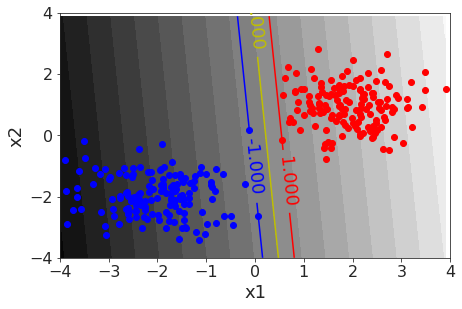

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, X, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], colors=['b', 'y', 'r'])
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

sns.set_style("ticks")
plt.figure(figsize=(7,4.5))
plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearly separable anymore.

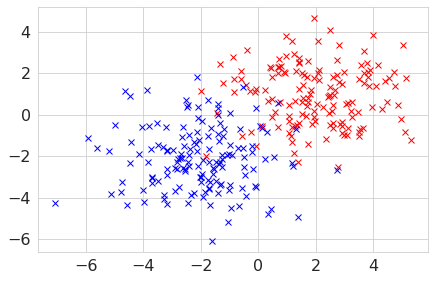

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
n, d = X.shape

sns.set_style("whitegrid")
plt.figure(figsize=(7,4.5))
plot_dataset(X, y)

In [ ]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, X, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
       <li>Check that constraints of the problem are now violated, can you explain what happened? How many are there according to the precision given in Question 7?</li>
    </ul>
</div>

In [ ]:
# TODO
eps = 1e-5
levels = y[:, None] * (X @ w.reshape((d,1)) + b)
len(levels[levels < 1 - eps]) # number of constraints violation
print(f'There are {len(levels[levels < 1 - eps])} violated constraints ')

There are 300 violated constraints 


**Answer 8:**

In the non linear separable case, all the contraints are violated. This means that the system of linear inequalities does not admit solution.

This is due to the fact that the model above is based on some assumption on the linear separability of the problem. The model is not adapted to non linearly separable problems.

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
         <li>Justify that $(P_{s})$ is a convex problem.</li>
         <li>Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div>

- **Let's justify that $(\mathcal{P}_s)$ is a convex problem**

 $f: (w,b,\xi) \mapsto \frac{1}{2} w^Tw = \frac{1}{2} \|w\|^2 + C \sum_i \xi_i$ is convex being the sum of a convex and a linear function.
 
 **Note:** A set $\mathcal{C} = \left\{ z: g(z) \leq 0 \right\}$ is convex if $g$ is convex. 
 
Now let $\mathcal{C} = \left\{(w,b, \xi)\in \mathbb{R}^d\times \mathbb{R};y_{i}(w^{\top}x_{i}+b)\geq 1 - \xi_i, - \xi_i \leq 0, \quad \forall i\in \{1,\cdots,n\}\right\} = \left\{(w,b, \xi)\in \mathbb{R}^d\times \mathbb{R};1 - \xi_i- y_{i}(w^{\top}x_{i}+b)\leq 0,  - \xi_i \leq 0,\quad \forall i\in \{1,\cdots,n\}\right\}   $
 
The function $g: (w,b,\xi) \mapsto 1 - \xi_i- y_{i}(w^{\top}x_{i}+b)$ is a linear convex, the set $\mathcal{C}$ is then convex.

Thus, the problem $(\mathcal{P}_s)$ is convex.

- **Let's find a dual problem of  $(\mathcal{P}_s)$**

First, the Lagrangian of the problem $(\mathcal{P})$ is defined as 
$$ \mathcal{L}(w,b,\xi,\mu, \lambda) = \frac{1}{2} \|w\|^2 + C \sum_i \xi_i + \sum_{i=1}^n \mu_i [1-\xi_i - y_i(w^{\top}x_i +b)] - \sum_{j=1}^n \lambda_j\xi_j$$
The dual of the problem is defined as 
 $$ (\mathcal{D}):~~~~~~~\sup_{\mu\geq 0\\ \lambda\geq 0} ~~\underbrace{\inf_{w,b,\xi} \mathcal{L}(w,b,\xi,\mu,\lambda)}_{*} $$
 
where $(*)$ is an unconstrained minimization problem that can be solved easily; by computing its partial derivatives and the stationnary points.    

The partial derivatives of the Lagrangian are given by 
$$
 \left\{
    \begin{array}{ll}
       \frac{\partial \mathcal{L} }{\partial w} = w - \sum_{i=1}^n \mu_i y_i x_i  \\
       \frac{\partial \mathcal{L} }{\partial b} = -\sum_{i=1}^n \mu_i y_i \\
       \frac{\partial \mathcal{L} }{\partial \xi} = C - \mu  - \lambda.
    \end{array}
\right.
$$
Leading to 
$$
 \left\{
    \begin{array}{ll}
       w^*& =& \sum_{i=1}^n \mu_i y_i x_i  \\
        \mu^{\top}y&=&0\\
        \lambda &=& C - \mu.
    \end{array}
\right.
$$

We plug $w^*$ in the Lagrangian obtaining:
\begin{align}
\inf_{w,b,\xi} \mathcal{L}(w,b,\xi,\mu,\lambda)=& \frac{1}{2} \|\sum_{i=1}^n \mu_i y_i x_i  \|^2 + C\sum_i \xi_i+ \sum_{i=1}^n \mu_i  -  \sum_{i=1}^n \mu_i \xi_i - \sum_{i,j=1}^n \mu_i y_i x_i^{\top}\mu_jy_jx_j - \underbrace{\sum_{i=1}^n \mu_i y_i b }_{=0} - \sum_{i=1}^n \lambda_i \xi_i\\
=& -\frac{1}{2} \sum_{i,j=1}^n \mu_i \mu_j x_i^{\top}x_j y_i y_j + \sum_{i=1}^n \mu_i  + C\sum_i \xi_i -\sum_{i=1}^n \mu_i \xi_i - \sum_{i=1}^n \lambda_i \xi_i\\
=& -\frac{1}{2} \mu^{\top}GG^{t}\mu + \mu^{\top}u  + C\sum_i \xi_i -\sum_{i=1}^n \mu_i \xi_i - \sum_{i=1}^n \lambda_i \xi_i
\end{align}

where  $u = (1, \dots, 1) \in \mathbb{R}^n$ and $$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$
We continue 
\begin{align}
\mathcal{L}(w,b,\xi,\mu,\lambda) =&  -\frac{1}{2} \mu^{\top}GG^{t}\mu + \mu^{\top}u   + \underbrace{ C\sum_i \xi_i -\sum_{i=1}^n \mu_i \xi_i }_{(1)}-\underbrace{\sum_{i=1}^n \lambda_i \xi_i}_{(2)}
\end{align}

\begin{align}
(1) =& 0 \mbox{ given the third condition} \frac{\partial \mathcal{L} }{\partial \xi} =0\\
(2) =& 0 \mbox{ given the complementarity condition of the KKT theorem}
\end{align}


Also, we have that $\lambda \geq 0$ and by the third condition $\frac{\partial \mathcal{L}}{\partial \xi} $ we have $\lambda= C - \mu$.

Hence the dual of the problem can be written as 

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{and}& 0 \leq \mu \leq C
\end{array}
\right .
$$


<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
       <li>Modify your code from Question 4 to handle the non-separable case.</li>
    </ul>
</div>

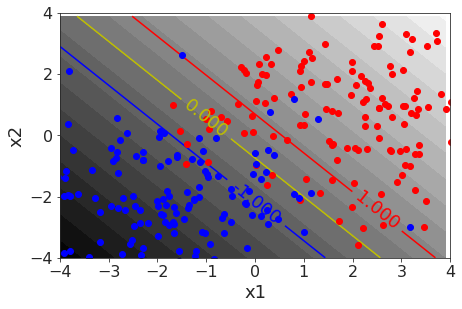

In [ ]:
# TODO
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, X, y, C=1)
b = compute_b(K, y, mu_support, idx_support)

sns.set_style("ticks")
plt.figure(figsize=(7,4.5))
plot_classif(X, y, mu_support, idx_support, b)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
       <li>What is the influence of C on the number of support vectors? Make a plot that demonstrates this empirically.</li>
    </ul>
</div>

**Answer 11**

The number of support vectors decreases as the value of $C$ increases. 
$C$ controls regularization, since C relaxes the constraints at the level of the boundaries of the classes. The more C grows the greater the relaxation and the less points verifying $y_i(w^{\top}x_i +b)= 1$. Hence, when $C$ grows we have less support vectors.

Text(0.5, 1.0, 'Number of support vectors in function of C')

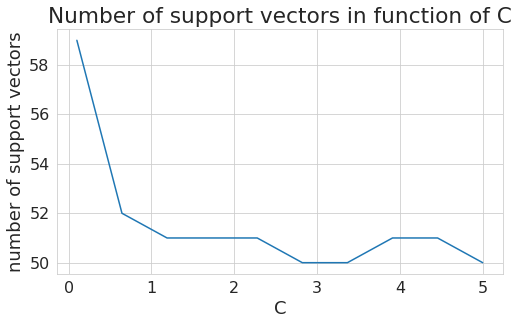

In [ ]:
reguls = np.linspace(0.1, 5, 10)
n_sv = np.zeros(10)

for i in range(10):
    _, idx_support = svm_solver(K, X, y, C=reguls[i])
    n_sv[i] = idx_support.size

sns.set_style("whitegrid")
plt.figure(figsize=(8,4.5))
plt.plot(reguls, n_sv)
plt.xlabel("C")
plt.ylabel("number of support vectors")
plt.title("Number of support vectors in function of C")

## Part 3: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
     <ul>
       <li>Denoting by $K(x_i, x_j)$ the dot product between samples, show that dual problem and the decision function f(x) can be reformulated just using calls to $K$</li>
    </ul>
</div> 

**Answer 12:**

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

If we denote $K(x_i, x_j)$ the dot product between samples, the dual problem can be written using $K$

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2} \sum_{i,j=1}^n \mu_iy_iK(x_i,x_j)y_j\mu_j-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$


As for the decission function 
\begin{align}
y =& \mathrm{sign}\left(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b\right) \enspace \\
=& \mathrm{sign}\left(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) + b\right)\enspace.
\end{align}


We will use the clowns dataset to evaluate this:

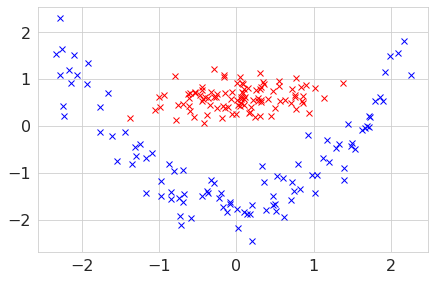

In [ ]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

sns.set_style("whitegrid")
plt.figure(figsize=(7,4.5))
plot_dataset(X, y)

<div class="alert alert-success">
    <b>QUESTION 13:</b>
     <ul>
       <li>Update your kernel function so it computes the Gaussian kernel:</li>
    </ul>
    $$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
$$

where $\gamma > 0$ is the kernel bandwidth.
</div> 

In [ ]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    # TO DO
    for i in range(n1):
        K[i] = np.exp(-gamma * linalg.norm(X1[i] - X2, axis=1)**2)
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

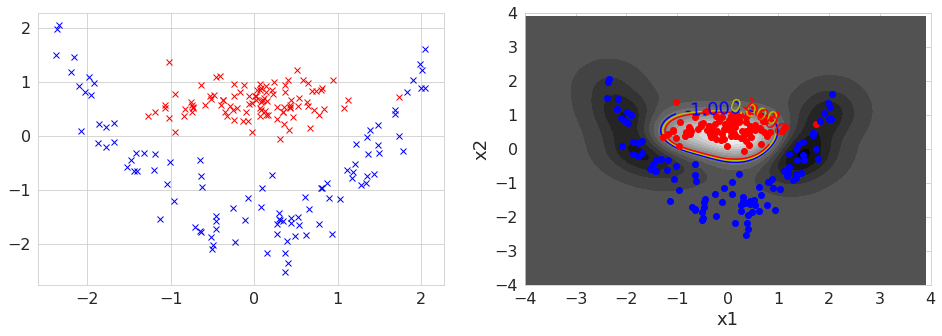

In [ ]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_dataset(X, y)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, X, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plt.subplot(1,2,2)
plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 4: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^\top \mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 14:</b>
     <ul>
       <li>Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div> 

- **Let's find a dual problem of  $(\mathcal{P}_s')$**

First, the Lagrangien of the problem $(\mathcal{P}_s')$ is defined as 
$$ \mathcal{L}(w,\xi,\mu, \lambda) = \frac{1}{2} \|w\|^2 + C \sum_i \xi_i + \sum_{i=1}^n \mu_i [1-\xi_i - y_i(w^{\top}x_i )] - \sum_{j=1}^n \lambda_j\xi_j$$
The dual of the problem is defined as 
 $$ (\mathcal{D}):~~~~~~~\sup_{\mu\geq 0\\ \lambda\geq 0} ~~\underbrace{\inf_{w,\xi} \mathcal{L}(w,\xi,\mu,\lambda)}_{*} $$
 
where $(*)$ is an unconstrained minimization problem that can be solved easily; by computing its partial derivatives and the stationnary points.    

The partial derivatives of the Lagrangien are given by 
$$
 \left\{
    \begin{array}{ll}
       \frac{\partial \mathcal{L} }{\partial w} = w - \sum_{i=1}^n \mu_i y_i x_i  \\
       \frac{\partial \mathcal{L} }{\partial \xi} = C - \mu -\lambda
    \end{array}
\right.
$$
Leading to 
$$
 \left\{
    \begin{array}{ll}
       w^*& =& \sum_{i=1}^n \mu_i y_i x_i  \\
        \lambda &=& \mu + C .
    \end{array}
\right.
$$

We plug $w^*$ in the Lagrangien obtaining:
\begin{align}
\inf_{w,\xi} \mathcal{L}(w,\xi,\mu,\lambda)=& \frac{1}{2} \|\sum_{i=1}^n \mu_i y_i x_i  \|^2 + C\sum_i \xi_i+ \sum_{i=1}^n \mu_i  -  \sum_{i=1}^n \mu_i \xi_i - \sum_{i,j=1}^n \mu_i y_i x_i^{\top}\mu_jy_jx_j -  \sum_{i=1}^n \lambda_i \xi_i\\
=& -\frac{1}{2} \sum_{i,j=1}^n \mu_i \mu_j x_i^{\top}x_j y_i y_j + \sum_{i=1}^n \mu_i  + C\sum_i \xi_i -\sum_{i=1}^n \mu_i \xi_i - \sum_{i=1}^n \lambda_i \xi_i\\
=& -\frac{1}{2} \mu^{\top}GG^{t}\mu + \mu^{\top}u  + C\sum_i \xi_i -\sum_{i=1}^n \mu_i \xi_i - \sum_{i=1}^n \lambda_i \xi_i
\end{align}

where  $u = (1, \dots, 1) \in \mathbb{R}^n$ and $$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$
We continue 
\begin{align}
\mathcal{L}(w,\xi,\mu,\lambda) =&  -\frac{1}{2} \mu^{\top}GG^{t}\mu + \mu^{\top}u   + \underbrace{ C\sum_i \xi_i -\sum_{i=1}^n \mu_i \xi_i }_{(1)}-\underbrace{\sum_{i=1}^n \lambda_i \xi_i}_{(2)}
\end{align}

\begin{align}
(1) =& 0 \mbox{ given the second condition} \frac{\partial \mathcal{L} }{\partial \xi} =0\\
(2) =& 0 \mbox{ given the complementarity condition of the KKT theorem}
\end{align}

In the other hand, $\lambda \geq 0$ and by the second condition $\frac{\partial \mathcal{L} }{\partial \xi} =0$ we have that $\lambda = \mu + C $


Hence the dual problem of $(\mathcal{P}_s')$ can be written as 


$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$


<div class="alert alert-success">
    <b>QUESTION 15:</b>
     <ul>
       <li>Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$
         </li>
    </ul>
</div>

We now want to rewrite the dual in the form

$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a separable non-smooth function.

In other terms, we want to replace a constrained optimization problem by a series of unconstrained problems whose solutions ideally converge to the solution of the original constrained problem. To do so, we use a penalty method using the indicator function of a set:

$$
\mathcal{I}_{\mathcal{C}}(x)=\left\{
\begin{array}{lll}
0 \mbox{ if } x\in \mathcal{C}\\
\infty  \mbox{ if } x\notin \mathcal{C}
\end{array}
\right .
$$

Thus, the dual problem can be rewritten as


$$
(\mathcal{D}): \min_{\mu} \frac{1}{2} \mu^{\top}GG^{\top}\mu - \mu^{\top}1_n + \sum_{i=1}^n \mathcal{I}_{[0,C]}(\mu_i)
$$


The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 16:</b>
     Implement:
     <ul>
       <li>your own version of proximal gradient with and without acceleration</li>
       <li>your own version of coordinate descent</li>
       <li>an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
    Test your implementations on the Gaussian blobs and evaluate the performance
    of your implementations in terms of computation time on problems where the matrix 
    $G G^\top$ can fit in memory. Give a short conclusion.
</div>

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is voluntary vague, but it is the most important and will constitute half of the final grade on the project ! We are waiting for beautiful plots, as well as sharp comments!**

### Preliminary computations
Before coding the algorithms we first need to determine the proximal operator and the lipschitz constants

- **Proximal operator**


We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$

Here, we want to solve 

$$
(\mathcal{D}): \min_{\mu} \underbrace{ \frac{1}{2} \mu^{\top}GG^{\top}\mu - \mu^{\top}1_n}_{f(\mu)} + \underbrace{\sum_{i=1}^n \mathcal{I}_{\mathcal{[0,C]}}(\mu_i)}_{R(\mu)}
$$

The proximal operator of ${R(\mu)}$ is given by
$$ \text{prox}_{R}(\mu) = \arg\min_z \left\{  \frac{1}{2} \Vert z - \mu\Vert_2^2 +  \,R(z) \right\} $$

and we have 
\begin{align}
\text{prox}_{R}(\mu_i) =& \arg\min_{z_i} \left\{ \frac{1}{2} \Vert z_i - \mu_i\Vert_2^2 +  \,R(z_i) \right\}\\
                              =& \arg\min_{z_i} \left\{ \frac{1}{2} \Vert z_i - \mu_i\Vert_2^2 +  \,\mathcal{I}_{\mathcal{[0,C]}}(z_i) \right\}\\
                              =& \arg\min_{z_i \\ z_i\in[0,C]} \left\{ \frac{1}{2} \Vert z_i - \mu_i\Vert_2^2  \right\}
\end{align}

Thus, the proximal operator is othogonal projection on the set $[0,C]$.

$$ \text{prox}_{R}(\mu_i) = \max( 0, \min(\mu_i,C))$$

- **Lipschitz constants**

- Let $ \nabla^2 f(\mu) = GG^{\top}$ such that $v^{\top} GG^{\top}v =\Vert G^{\top}v \Vert_2^2 \geq 0$.

Thus, $f$ is convex.

$\nabla f(\mu )= \sum_{j=1}^n y Xx_iy_j\mu_j - 1_n$ and $ \frac{\partial f}{\partial \mu_i}= \sum_{j=1}^n y_i x_i^{\top} x_iy_j\mu_j - 1$
We have
\begin{align}
f_{\mu,i}(h)=& f(\mu +e_ih)=  \frac{1}{2} (\mu +e_ih)^{\top}GG^{\top}(\mu+e_ih)-(\mu+e_ih)^{\top}1_n\\
f_{\mu,i}'(h)=& hy_i^2\Vert x_i \Vert_2^2 -1+2\mu_iy_i\Vert x_i \Vert_2^2\\
f_{\mu,i}''(h)=& y_i^2\Vert x_i \Vert_2^2 = \Vert x_i \Vert_2^2~~ \mbox{ because } y_i\in\{-1,1\}\\
\implies& f_{\mu,i} \mbox{ is } \Vert x_i \Vert_2^2\mbox{-Lipschitz}.
\end{align}
 And thus $ \frac{\partial f}{\partial \mu_i}$  is $\Vert x_i \Vert_2^2$-Lipschitz.


- On the other hand, using the fact that 

$$ 
\frac{1}{2} \Vert y \Vert_2^2 \leq \frac{1}{2} \Vert x \Vert_2^2 +  \langle x,y-x\rangle + \frac{1}{2} \Vert y-x \Vert_2^2 $$
and that $\frac{1}{2} \Vert . \Vert_2^2$ is 1-Lipschitz.

We obtain
\begin{align}
\frac{1}{2} \Vert G\mu\Vert_2^2 \leq&~~ \frac{1}{2} \Vert G\nu \Vert_2^2 +  \langle G\nu,G(\mu-\nu)\rangle+ \frac{1}{2} \Vert G(\mu-\nu) \Vert_2^2\\
\leq&~~ \frac{1}{2} \Vert G\nu \Vert_2^2 + (G\nu)^{\top}G(\mu-\nu)+ \frac{1}{2} \sigma_{max}(G)^2\Vert \mu-\nu\Vert_2^2\\
\leq&~~ \frac{1}{2} \Vert G\nu \Vert_2^2 + \nu^{\top}G^{\top}G(\mu-\nu) + \frac{1}{2} \sigma_{max}(G)^2\Vert \mu-\nu\Vert_2^2
\end{align}

Hence, $x \mapsto \frac{1}{2}  \Vert Gx \Vert_2^2$ is $\sigma_{max}(G)^2$-Lipschitz and so is $f$.



### Loss function, proximal operator and gradient

In [ ]:
from scipy import sparse
from scipy import linalg

In [ ]:
# TODO
def loss(mu, GG_t, C):
    n = len(mu)
    reg = 0
    for i in range(n):
        if (mu[i] < 0) or (mu[i] > C):
            reg += 10
    
    return 0.5 * mu.T @ GG_t @ mu - np.sum(mu) + reg


def prox_g(mu, C):
    return np.maximum(0, np.minimum(mu, C))


def grad_f(mu, GG_t, C):
    return GG_t @ mu - np.ones(len(mu))

### A class to monitor iterations

In [ ]:
class monitor:
    def __init__(self, algo, loss, obj_star, mu_star, args=()):
        self.loss = loss
        self.mu_star = mu_star
        self.algo = algo
        self.obj_star = obj_star
        self.args = args
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        obj_list, mu_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.mu_list = mu_list
        self.err = [linalg.norm(mu - self.mu_star) for mu in mu_list]
        self.obj = [np.maximum(self.loss(mu, *self.args) - self.obj_star,0) for mu in mu_list]

### Proximal gradient descent

In [ ]:
def proxgd_dualsvm(mu_init, prox, lips_const, n_iter=100, args=()):
    mu = mu_init.copy()
    n = len(mu)
    mu_list = []
    GG_t, C = args
    GG_t = GG_t.toarray()
    
    for t in range(n_iter):
        grad = GG_t @ mu - np.ones(n)
        mu_old = mu.copy()
        mu = prox(mu_old - grad_f(mu_old, GG_t, C) / lips_const , C)
        mu_list.append(mu.copy())   

    return mu, mu_list

### Accelerated proximal gradient descent

In [ ]:
def proxagd_dualsvm(mu_init, prox, lips_const, n_iter=100, args=()):
    mu = mu_init.copy()
    n = len(mu)
    mu_list = []
    GG_t, C = args
    GG_t = GG_t.toarray()
    beta_old = 1.
    z_old = mu_init.copy()

    for t in range(n_iter):
        grad = GG_t @ mu - np.ones(n)
        mu_old = mu.copy()

        mu = prox(z_old - grad_f(z_old, GG_t, C) / lips_const , C)
        beta = (1 + np.sqrt(1 + 4*beta_old**2)) / 2
        z = mu + (beta_old - 1) * (mu - mu_old) / beta

        beta_old = beta.copy() 
        z_old = z.copy()
        mu_list.append(mu.copy())   

    return mu, mu_list

### Proximal coordinate descent

In [ ]:
def proxcd_dualsvm(mu_init, prox, grad, lips_const, n_iter=100, args=()):
    mu = mu_init.copy()
    n = len(mu)
    mu_list = []
    GG_t, C = args
    
    g = grad(mu, GG_t, C)
    Q = GG_t.toarray()
    
    iis = np.random.randint(0,n,n_iter)
    
    for t in range(n_iter):
        i = iis[t]
        old_mu = mu.copy()
        mu[i] = prox(old_mu[i] - g[i] / lips_const[i], C)
        g -= Q[:,i] * (old_mu[i] - mu[i])
        
        if t % n == 0:
            mu_list.append(mu.copy())
    
    return mu, mu_list

### BONUS: Proximal coordinate descent with shrinking

Since the dual problem is constrained, the $\mu_i$ multipliers can stay on one of the bounds of the set $[0,C]$, so there are multipliers that do not change values over iterations. We can think of decreasing the training time by shrinking these multipliers.

There are heuristics to choose the multipliers to shrink, we based ourselves on the ones presented in the article <a href="https://www.researchgate.net/publication/312450680_A_dual_coordinate_descent_method_for_large-scale_linear_SVM"> A dual coordinate descent method for large-scale linear SVM by C.J. Hsiehn, C.J. Lin and Kai-Wei Chang. </a> 
 

In [ ]:
def proxcd_shrink(mu_init, prox, grad, lips_const, max_iter=100, eps=1e-30, n_pass_max=2, args=()):
    mu = mu_init.copy()
    n = len(mu)
    mu_list = []
    GG_t, C = args
    
    g = grad(mu, *args)
    Q = GG_t.toarray()
    g0 = g[mu==0].copy()
    gC = g[mu==C].copy()
    g_proj = g.copy()
    g_proj[mu==0] = np.minimum(0, g0)
    g_proj[mu==C] = np.maximum(0, gC)
    M, m = np.max(g_proj), np.min(g_proj)
    
    t, shrink_in = 0, n
    vars_not_shrunk = np.arange(0,n)
    iis = np.random.permutation(vars_not_shrunk)
    l = len(iis)
    
    while (t != max_iter) and (M == m or M - m >= eps):
        if shrink_in != 0:
            i = iis[l - shrink_in]
            old_mu = mu.copy()
            mu[i] = prox(old_mu[i] - g[i] / lips_const[i], C)
            g[vars_not_shrunk] -= Q[vars_not_shrunk,i] * (old_mu[i] - mu[i])
            if mu[i] == 0:
                g_proj[i] = np.minimum(0,g[i])
            elif mu[i] == C:
                g_proj[i] = np.maximum(0,g[i])
            M = np.maximum(M,g_proj[i])
            m = np.minimum(m,g_proj[i])
            shrink_in -= 1
        else:
            M2 = M if M > 0 else np.inf
            m2 = m if m < 0 else -np.inf
            temp = vars_not_shrunk
            vars_not_shrunk = []
            M = -np.inf
            m = np.inf
            for j in temp:
                if (mu[j] != 0 or g[j] > M2) and (mu[j] != C or g[j] < m2):
                    vars_not_shrunk.append(j)
                    M, m = np.maximum(M,g_proj[j]), np.minimum(m,g_proj[j])
            n_pass = n_pass_max if len(vars_not_shrunk) < 1000 else 1
            shrink_in = n_pass * len(vars_not_shrunk)
            iis = np.random.choice(vars_not_shrunk, shrink_in)
            l = len(iis)
        if t % n == 0:
            mu_list.append(mu.copy())
        t += 1
        
    
    return mu, mu_list

### scipy.optimize's L-BFGS-B

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

class callback():
    def __init__(self):
        self.mu_list = []
    
    def __call__(self, mu):
        self.mu_list.append(mu.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        mu = scipy_algo(*args, **kwargs, callback=cb)
        return mu, cb.mu_list
    return run

### Numerical comparison

In [ ]:
# Some plot functions
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$obj(mu_k) - obj(mu^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|mu_k - mu^*\|_2$")

    plt.legend(solvers)

    
def plot_time(monitors, solvers):
    plt.figure(figsize=(7.5, 5))
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$obj(mu_k) - obj(mu^*)$")

    plt.legend(solvers)

In [ ]:
# Hyperparameters and simulated data
X, y = datasets(name='gaussian', n_points=100, sigma=0.7)
n = X.shape[0]
X = np.hstack((X, np.ones((n,1))))
y = y[:,None]
C = 30

yX = sparse.csr_matrix(y * X)
GG_t = yX @ yX.T

In [ ]:
# get a precise minimum
mu_init = np.zeros(n)
constraints = [(0,C) for i in range(n)]

mu_star, obj_star, _ = fmin_l_bfgs_b(loss, mu_init, grad_f, args=(GG_t, C), bounds=constraints, pgtol=1e-30, factr=1e-30)

In [ ]:
mu_init = np.zeros(n)
n_epoch = 100
lips_const = linalg.norm(X, axis=1)**2

monitor_proxcd = monitor(proxcd_dualsvm, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxcd.run(mu_init, prox_g, grad_f, lips_const, n_iter=n_epoch * n, args=(GG_t, C))

In [ ]:
monitor_lbfgsb = monitor(scipy_runner(fmin_l_bfgs_b), loss, obj_star, mu_star, args=(GG_t, C))
monitor_lbfgsb.run(loss, mu_init, grad_f, args=(GG_t, C), maxiter=100, bounds=constraints, pgtol=1e-30)

In [ ]:
#Lipschitz constant for the proximal gradien descent
lips_const = linalg.norm(X)**2

monitor_proxgd = monitor(proxgd_dualsvm, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxgd.run(mu_init, prox_g, lips_const, n_iter=100 , args=(GG_t, C))

In [ ]:
monitor_proxagd = monitor(proxagd_dualsvm, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxagd.run(mu_init, prox_g, lips_const, n_iter=100 , args=(GG_t, C))

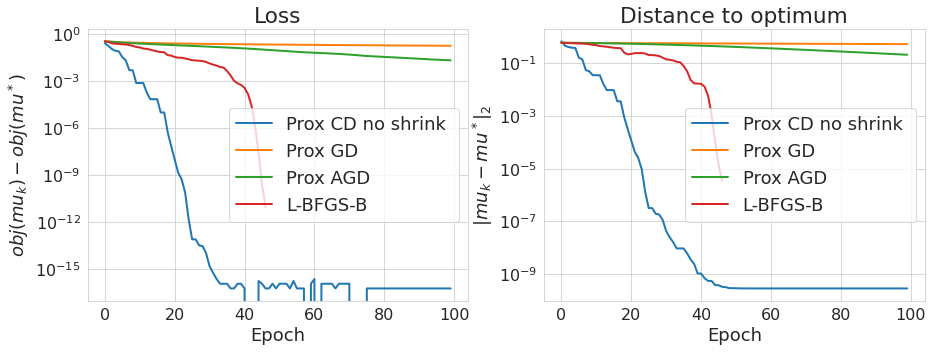

In [ ]:
monitors = [monitor_proxcd,  monitor_proxgd, monitor_proxagd, monitor_lbfgsb]

solvers = ["Prox CD no shrink ", "Prox GD", "Prox AGD", "L-BFGS-B"]

plot_epochs(monitors, solvers)

In terms of epochs we see that proximal coordinate descent and LBFGS-B algorithms are the fastest, prox gd and fista are much slower.

- **Comparing prox cd and prox gd:**

Both of iteration complexities of the coordinate and the gradient descent depend on the Lipschitz constant. Given that $L_i \leq L$, this lead to a faster convergence for the prox cd.

We also justify these results by the fact that the cost of an iteration of prox cd is of the order of the cost of evaluation one partial derivative when the cost of one iteration of prox gd is of the order of the cost of evaluation of the whole gradient.

- **Comparing LBFGS-B and prox gd:**

Since, $f$ is a quadratic function, the quasi-Newton methods behave like conjugate gradient descent.In this case, the conjugate gd converges in less than $n$ iterations. Contrary to the conjugate gd, the gd uses the steepest direction independently of the previous iterations. Hence, that explains why LBFGS-b is faster.

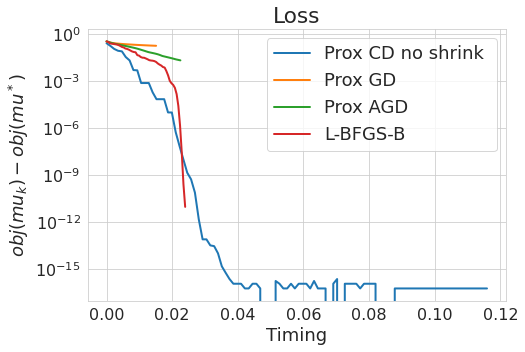

In [ ]:
plot_time(monitors, solvers)

We remark that LBFGS-B and prox cd have the best perfomances in term of execution time with respect to the achieved precision.

### Numerical comparison between prox cd with and without shrinking and L-BFGS-B



In [ ]:
mu_init = np.zeros(n)
n_epoch = 60
lips_const = linalg.norm(X, axis=1)**2

monitor_proxcd = monitor(proxcd_dualsvm, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxcd.run(mu_init, prox_g, grad_f, lips_const, n_iter=n_epoch * n, args=(GG_t, C))

In [ ]:
mu_init = np.zeros(n)
monitor_proxcd_shrink = monitor(proxcd_shrink, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxcd_shrink.run(mu_init, prox_g, grad_f, lips_const, max_iter=n_epoch * n, args=(GG_t, C))

In [ ]:
monitor_lbfgsb = monitor(scipy_runner(fmin_l_bfgs_b), loss, obj_star, mu_star, args=(GG_t, C))
monitor_lbfgsb.run(loss, mu_init, grad_f, args=(GG_t, C), bounds=constraints, pgtol=1e-30)

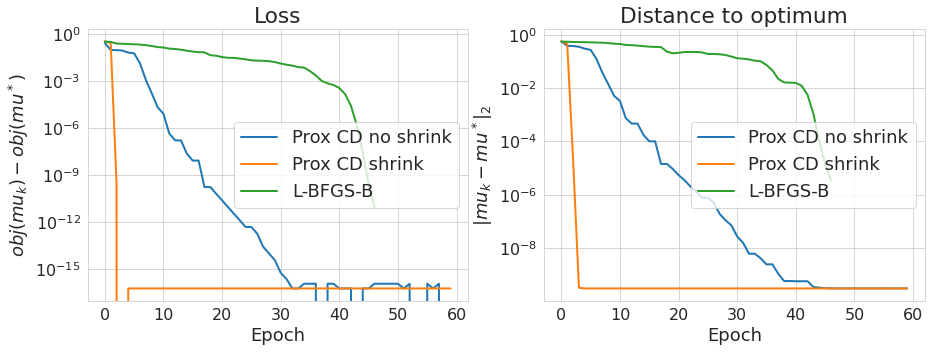

In [ ]:
monitors = [monitor_proxcd, monitor_proxcd_shrink, monitor_lbfgsb]

solvers = ["Prox CD no shrink", "Prox CD shrink", "L-BFGS-B"]

plot_epochs(monitors, solvers)

Here, we can remark that the proximal coordinate descent with shrinking has litteraly no time to loose. The fact we shrunk some variables helped accelerating the descent.  Indeed, removing the less significant variables help finding the most relevent descent direction at each epoch.





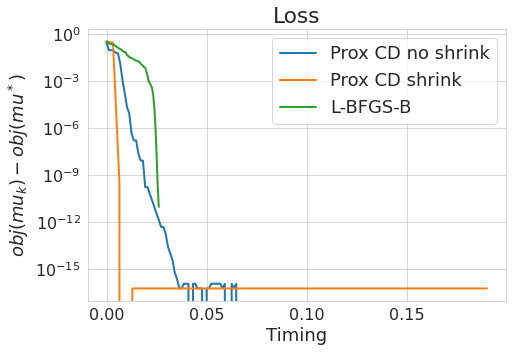

In [ ]:
plot_time(monitors, solvers)

Although, the proximal coordinate descent with shrinking outperforms the other algorithms in term of precision, it takes a considerable amount of time to shrink the variables.

### Numerical *comparison* with ten thousands samples
In this part we compare the perfomances of the coordinate descent and its ameliorated version on a large number of samples.

In [ ]:
# Hyperparameters and simulated data
X, y = datasets(name='gaussian', n_points=10000, sigma=0.4)
n = X.shape[0]
X = np.hstack((X, np.ones((n,1))))
y = y[:,None]
C = 30.

lips_const = linalg.norm(X, axis=1)**2
yX = sparse.csr_matrix(y * X)
GG_t = yX @ yX.T

In [ ]:
# get a precise minimum
mu_init = np.zeros(n)
constraints = [(0,C) for i in range(n)]

mu_star, obj_star, _ = fmin_l_bfgs_b(loss, mu_init, grad_f, args=(GG_t, C), bounds=constraints, pgtol=1e-30, factr=1e-30)

In [ ]:
n_epoch = 10
monitor_proxcd = monitor(proxcd_dualsvm, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxcd.run(mu_init, prox_g, grad_f, lips_const, n_iter=n_epoch * n, args=(GG_t, C))

In [ ]:
monitor_proxcd_shrink = monitor(proxcd_shrink, loss, obj_star, mu_star, args=(GG_t, C))
monitor_proxcd_shrink.run(mu_init, prox_g, grad_f, lips_const, max_iter=10 * n, args=(GG_t, C), n_pass_max=3)

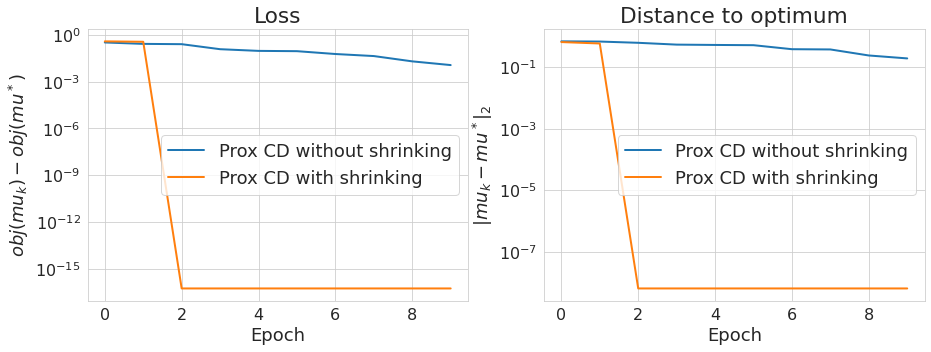

In [ ]:
monitors = [monitor_proxcd, monitor_proxcd_shrink]
solvers = ["Prox CD without shrinking", "Prox CD with shrinking"]

plot_epochs(monitors, solvers)

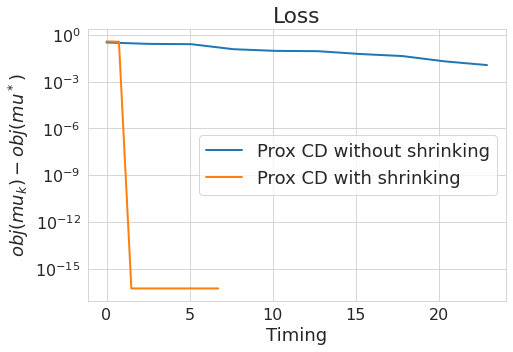

In [ ]:
plot_time(monitors, solvers)

When dealing with huge amount the samples, the proximal coordinate descent with shrinking has a better performance in term of time execution. Although, the shrinking method take some time to remove the variables, it is then recovered later when the epochs get more and more faster.

**Remark:** Our proximal coordinate descent with shrinking can be unstable especially when dealing with huge data samples. Our algorithm takes a parameter `n_pass_max` which controls when the shrinking is done. If `n_pass_max`  is too small then the shrinking can be too brutal and causes instability. It is then important to choose it correctly.

## Part 5: SVM Rank

You will now use the code you have written above to answer the following question: given two samples $x_i$ and $x_j$ in $\mathbb{R}^p$, with corresping labels $y_i$ and $y_j$ in $\mathbb{R}$ (note that now labels can be any real number, it's not just binary). Can I predict if $y_i > y_j$ or the oppositve?

To take a concrete example, imaging you go to a liquor store to buy a bottle on wine and you hesitate between two bottles. The SVM Rank model below will tell you if the quality of the wine encoded in the target $y$ is better for the first bottle or the second one.

Let's formalize this a bit. We aim to estimate a linear function $f_{w}(x) = x^\top w$ that minimizes
the following risk:

$$
\mathcal{R}_f=\mathbb{E}
    \left[
    \ell(f_w(x_i) - f_w(x_j), \mathrm{sign}(y_i-y_j))
    \right]
$$

where the loss $\ell$ is the Hinge loss of the SVM binary classifical model you have seen above. Namely:
$
    \ell(z, t) = \max(1 - tz, 0)
$ . Note that we limit ourselves here to linear SVM.

This leads to the following regularized empirical risk minimization problem:

$$
\hat{w} = \mathrm{arg}\,\min_{w \in \mathbb{R}^p} \left( C \sum_{i,j} \ell((x_i - x_j)^\top w, \mathrm{sign}(y_i-y_j)) + \|w\|_2^2 \right),
$$


This part is inspired by the following works:

    - R. Herbrich, T. Graepel, and K. Obermayer. Large margin rank boundaries for ordinal regression. MIT Press, Cambridge, MA, 2000.

    - T. Joachims. Optimizing search engines using clickthrough data. In Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining, pages 133–142, New York, NY, USA, 2002. ACM. 2
    
The following cell implements the `transform_pairwise` function. Given `X` and `y` this function builds all the pairs of samples to output a new dataset that corresponds to a binary classification problem. It basically outputs the differences between feature vectors and the sign of the difference of the targets.

In [ ]:
import itertools


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking

    Transforms a n-class ranking problem into a two-class classification
    problem.

    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        Target labels.

    Returns
    -------
    X_trans : array, shape (n_pairs, n_features)
        Data formed by difference of feature vectors.
    y_trans : array, shape (n_pairs,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    comb = itertools.combinations(range(X.shape[0]), 2)
    k = 0
    for (i, j) in comb:
        if y[i] == y[j]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i] - y[j]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        k += 1
    return np.array(X_new), np.array(y_new)

<div class="alert alert-success">
    <b>QUESTION 17:</b>
     The following cell implements a scikit-learn estimator for the SVM Rank
     model. It uses the liblinear solver shipped with scikit-learn.
     <ul>
       <li>Update the following code to use a solver developed above instead of scikit-learn LinearSVC estimator.
         You will justify this choice of solver in terms of performance
         based your experiments above.</li>
       <li>Run your updated estimator on the Wine quality dataset
         and compare the performance of your model with the liblinear
         solver. You will compare in terms of prediction score
         and in terms of computation time.</li>
    </ul>
</div>

**Note:** For the scorer we use here the [Kendall's rank correlation](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

$$
    \tau ={\frac {2}{n(n-1)}}\sum _{i<j}\operatorname {sgn}(x_{i}-x_{j})\operatorname {sgn}(y_{i}-y_{j})
$$

implemented in `scipy.stats.kendalltau`.

In [ ]:
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, RegressorMixin


class RankSVM(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        """
        self.svc_ = svm.LinearSVC(loss='hinge', dual=True, tol=1e-2,
            fit_intercept=True, C=self.C, max_iter=1000000)
        X_trans, y_trans = transform_pairwise(X, y)
        self.svc_.fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.svc_.coef_.T).ravel())

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

In [ ]:
# TO DO

class RankSVM2(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model
       and an optimization by a proximal coordinate descent method with shrinking

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model. """
        X_trans, y_trans = transform_pairwise(X, y)
        n = X_trans.shape[0]
        X_trans = np.hstack((X_trans, np.ones((n,1))))
        y_trans = y_trans[:,None]
        lips_const = linalg.norm(X_trans, axis=1)**2
        yX = sparse.csr_matrix(y_trans * X_trans)
        GG_t = yX @ yX.T
        mu_init = np.zeros(n)
        mu_star, _ = proxcd_shrink(mu_init, prox_g, grad_f, lips_const, max_iter=5 * n, eps=1e-2,
                                   args=(GG_t, C))
        mu_star = np.expand_dims(mu_star, axis=1)
        self.coef_ = mu_star.T @ yX[:,:-1]
        print("Fit operation finished")
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X. """
        return np.argsort(np.dot(X, self.coef_.T).ravel())

    def score(self, X, y):
        """Score using Kendall rank correlation """
        return stats.kendalltau(self.predict(X), y)[0]

In [ ]:
# Loading the data
import pandas as pd
from sklearn.model_selection import cross_val_score

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.head()

In [ ]:
df_small = df.iloc[:270]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values
y = df_small.quality.values
print("Data set before transformation into pairs: ",X.shape)
X_trans, _ = transform_pairwise(X, y)
print("After transformation: ",X_trans.shape)

In [ ]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), RankSVM(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

In [ ]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(RankSVM2(C=1.))
scores = cross_val_score(clf, X, y, cv=2)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())